# 作業二 : 單根 ADF檢定

    樣本標的 : 0052 富邦科技 ETF
    樣本區間 : 2020/06/10 ~ 2021/06/11，共 246 天
    資料來源 : CMONEY 日收盤表排行

In [175]:
df = pd.read_excel("富邦科技.xls", sheet_name = '工作表1')
df.sort_index(ascending=False, inplace=True)
df.reset_index(inplace=True)
df = df[['收盤價', '漲幅(%)']]
df

,收盤價,漲幅(%)
0,68.6900,1.2400
1,68.0000,-1.0100
2,67.5500,-0.6600
...,...,...
243,122.6000,-0.8100
244,124.7500,1.7500
245,125.4500,0.5600


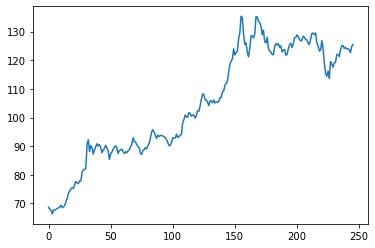

In [176]:
plt.plot(df['收盤價'])

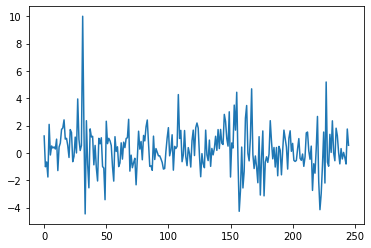

In [177]:
plt.plot(df['漲幅(%)'])

## 單根 ADF檢定

<img src="https://i.imgur.com/xgPvaTq.png" width="35%">

In [178]:
# 當日收盤價，246列
close = df['收盤價']

# T-1 期收盤價，第一列nan，246列
lag_close = close.shift(1)

# T-1 期收盤價，拿掉第一列nan，245列
lag_close_1 = lag_close.drop(index=[0 ,0]) 

# delta = T - (T-1期)，都是 246 列
delta_close = close - lag_close

# delta，拿掉第 1 列，剩 245 列
delta_close_1 = delta_close.drop(index=[0, 0])

df_merge = pd.concat([close, lag_close, delta_close], axis=1)
df_merge.columns = ['T','T-1','△T']
df_merge

,T,T-1,△T
0,68.6900,nan,nan
1,68.0000,68.6900,-0.6900
2,67.5500,68.0000,-0.4500
...,...,...,...
243,122.6000,123.6000,-1.0000
244,124.7500,122.6000,2.1500
245,125.4500,124.7500,0.7000


In [179]:
# y = delta_close_1， x = lag_close_1
model=sm.OLS(delta_close_1, sm.add_constant(lag_close_1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    收盤價   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.317
Date:                Sat, 12 Jun 2021   Prob (F-statistic):              0.129
Time:                        00:50:47   Log-Likelihood:                -479.55
No. Observations:                 245   AIC:                             963.1
Df Residuals:                     243   BIC:                             970.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1374      0.605      1.880      0.0

C:\Users\sandy\Anaconda3\envs\Quantative\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<img src="https://i.imgur.com/z8pvz0N.png" width="80%">

    結論 : 
        t = -1.522 > -2.57 
        不拒絕虛無假設，此數列存在單根，為非穩定態數列。

## 測試效率市場

###  1. 利用迴歸式

In [180]:
x = df['漲幅(%)'].drop(index=[0, len(df)-1])
x = x.reset_index(drop=True)
y = df['漲幅(%)'].drop(index=[0, 1])
y = y.reset_index(drop=True)

In [181]:
# y = T的return， x = T-1的return
model=sm.OLS(y, sm.add_constant(x)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  漲幅(%)   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.167
Date:                Sat, 12 Jun 2021   Prob (F-statistic):             0.0764
Time:                        00:50:47   Log-Likelihood:                -460.99
No. Observations:                 244   AIC:                             926.0
Df Residuals:                     242   BIC:                             933.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2348      0.104      2.253      0.0

C:\Users\sandy\Anaconda3\envs\Quantative\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


    結論 : 
        z = 0.076 > 0.05，不顯著，是效率市場

###  2. 利用ARIMA
時間序列分析模型:

    ● 自回歸模型-AR模型
    ● 移動平均模型-MA模型
    ● 自回歸滑動平均模型-ARMA模型
    ● 差分整合移動平均自迴歸模型-ARIMA模型

ARMA模型是將上面兩種整合在一起的產物，而ARIMA則是以ARMA做優化的產品，能將非穩定的資料處理成穩定的資料。

https://www.itread01.com/content/1546278962.html

https://ithelp.ithome.com.tw/articles/10252815

arima_model.ARIMA(一數列, order=( lag幾期, 差分次數, MA ))

In [182]:
from statsmodels.tsa import arima_model
model2 = arima_model.ARIMA(df['漲幅(%)'], order=(1,0,0)).fit()
print(model2.summary())

                              ARMA Model Results                              
Dep. Variable:                  漲幅(%)   No. Observations:                  246
Model:                     ARMA(1, 0)   Log Likelihood                -464.334
Method:                       css-mle   S.D. of innovations              1.598
Date:                Sat, 12 Jun 2021   AIC                            934.668
Time:                        00:50:47   BIC                            945.184
Sample:                             0   HQIC                           938.902
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2635      0.115      2.300      0.021       0.039       0.488
ar.L1.漲幅(%)     0.1111      0.063      1.756      0.079      -0.013       0.235
                                    Roots       

C:\Users\sandy\Anaconda3\envs\Quantative\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


    結論 : 
        z = 0.079 > 0.05，不顯著，是效率市場